Cargo el dataset, se eliminan filas vacías y se muestran las primeras reseñas para verificar los datos.


In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv("baby_reviews_small.csv")
df = df.dropna(subset=["reviewText", "sentiment"])  # por seguridad

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sentiment
0,A1OFPQMJWMM4XM,B002OHD3XS,"KARARED ""Kc""","[0, 0]",I love this booster. We have two and it's wel...,5,Love this booster....SAFETY FIRST!!!!!,1368403200,"05 13, 2013",1
1,A1Z94P3Q8O0D21,B00354UNSM,Jana Pettus,"[1, 1]","This has a million parts, is hard to wash, and...",1,Don't waste your money,1393891200,"03 4, 2014",0
2,A1V981XARKIMNT,B001KZJY2O,Chad and Kristen,"[1, 2]",This pillow probably cost less than a dollar t...,1,Terrible quality - do not buy this pillow,1367193600,"04 29, 2013",0
3,A1TCX0R35T4WEH,B000056J2D,"MomOf2BOYS ""Lucy""","[1, 2]","My 2 1/2 year olds highchair was terrible, so ...",5,Great booster,1115683200,"05 10, 2005",1
4,A1N54YHG0KQI91,B001PBFWMO,Toddler Mom,"[1, 1]",We got this when our daughter was only a few m...,5,We LOVE this!,1358899200,"01 23, 2013",1


Se aplica la función de limpieza a cada review y se crea una columna nueva con el texto preprocesado.


In [17]:
import re
from bs4 import BeautifulSoup

def preprocess_for_w2v(text):
    if not isinstance(text, str):
        return ""
    # quitar HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    # minúsculas
    text = text.lower()
    # quitar cosas raras
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    # colapsar espacios
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["review"] = df["reviewText"].apply(preprocess_for_w2v)
df[["reviewText", "review"]].head()

,reviewText,review
0,I love this booster. We have two and it's wel...,i love this booster we have two and it s well ...
1,"This has a million parts, is hard to wash, and...",this has a million parts is hard to wash and i...
2,This pillow probably cost less than a dollar t...,this pillow probably cost less than a dollar t...
3,"My 2 1/2 year olds highchair was terrible, so ...",my 2 1 2 year olds highchair was terrible so i...
4,We got this when our daughter was only a few m...,we got this when our daughter was only a few m...


Se divide el dataset en train y test manteniendo el balance de clases y se crean dataframes con los textos de entrenamiento y prueba.


In [18]:
from sklearn.model_selection import train_test_split

X = df["review"]
y = df["sentiment"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_words = pd.DataFrame(X_train, columns=["review"])
X_test_words = pd.DataFrame(X_test, columns=["review"])

X_train_words.head()

,review
4487,the wrap is long enough but in my opinion not ...
2027,great items i have tried several different ute...
880,easy for my 14 month daughter to use minimal s...
1690,as a first time cloth diaperer i have to say t...
2734,i purchased a set of these nuby bottles due to...


In [19]:
!pip install gensim

Se crean el tokenizer, el modelo Word2Vec entrenado con las reviews y la matriz de embeddings que usará la red neuronal.


In [20]:
import gensim
import multiprocessing as mp

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 5
W2V_MIN_COUNT = 2

SEQUENCE_LENGTH = 500

def generate_tokenizer(train_texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_texts)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Total words (vocab_size): {vocab_size}")
    return tokenizer, vocab_size

def generate_word2vec(train_df):
    documents = [_text.split() for _text in train_df.review]
    w2v_model = gensim.models.Word2Vec(
        vector_size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)

    words = list(w2v_model.wv.key_to_index.keys())
    vocab_size = len(words)
    print(f"Vocab size in Word2Vec: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model

def generate_embedding(word2vec_model, vocab_size, tokenizer):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    embedding_layer = Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        trainable=False,
    )
    return embedding_layer

Se convierten los textos en secuencias numéricas, se rellenan a una longitud fija y se genera la capa de embeddings antes de construir el modelo LSTM.


In [21]:
tokenizer, vocab_size = generate_tokenizer(X_train_words.review)

word2vec_model = generate_word2vec(X_train_words)

Total words (vocab_size): 12123
Vocab size in Word2Vec: 7086


In [22]:
X_train_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_train_words.review),
    maxlen=SEQUENCE_LENGTH
)

X_test_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_test_words.review),
    maxlen=SEQUENCE_LENGTH
)

X_train_seq.shape, X_test_seq.shape

((3996, 500), (1000, 500))

In [23]:
embedding_layer = generate_embedding(word2vec_model, vocab_size, tokenizer)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_w2v_lstm = Sequential()
model_w2v_lstm.add(embedding_layer)
model_w2v_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_w2v_lstm.add(Dense(1, activation="sigmoid"))

model_w2v_lstm.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_w2v_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     3,636,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,636,900 (13.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,636,900 (13.87 MB)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    verbose=1
)

history = model_w2v_lstm.fit(
    X_train_seq,
    y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5549 - loss: 0.6789 - val_accuracy: 0.5788 - val_loss: 0.6783 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.6152 - loss: 0.6502 - val_accuracy: 0.6087 - val_loss: 0.6599 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.6518 - loss: 0.6137 - val_accuracy: 0.6438 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.6632 - loss: 0.6121 - val_accuracy: 0.6650 - val_loss: 0.6233 - learning_rate: 0.0010
Epoch 5/10
30/50 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6887 - loss: 0.5899

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_prob = model_w2v_lstm.predict(X_test_seq)
y_pred = (y_pred_prob > 0.5).astype("int32").ravel()

print("=== RNN + Word2Vec (LSTM) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step
=== RNN + Word2Vec (LSTM) ===
Accuracy: 0.716

Classification report:

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       500
           1       0.77      0.61      0.68       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.71      1000
weighted avg       0.73      0.72      0.71      1000


Matriz de confusión:
 [[409  91]
 [193 307]]


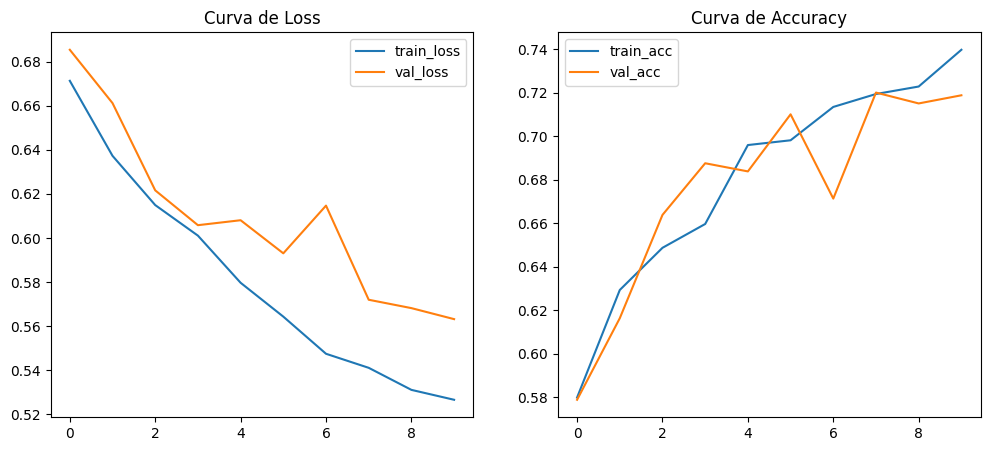

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Curva de Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Curva de Accuracy")
plt.legend()

plt.show()

In [14]:
wrong_idx = (y_pred != y_test)
X_test_words_wrong = X_test_words[wrong_idx].head()
X_test_words_wrong

,review
2937,so glad i bought this hands free bra it just r...
4709,these are good quality the included double sid...
3335,after our baby got his arms and legs stuck in ...
4508,update i bought this stroller and originally g...
3503,i received this set as a shower gift and was e...


In [15]:
for i in range(5):
    print("Texto:", X_test_words.iloc[wrong_idx].review.iloc[i])
    print("Predicción:", y_pred[wrong_idx][i], " - Real:", y_test[wrong_idx].iloc[i])
    print("----")

NotImplementedError: iLocation based boolean indexing on an integer type is not available